In [1]:
import sys
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import re

import gensim
from gensim.parsing.preprocessing import remove_stopwords
from gensim.parsing.porter import PorterStemmer

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score
from sklearn.utils import shuffle

import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Flatten, Dropout, Dense, LSTM, Embedding
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping

from sklearn.metrics import confusion_matrix, accuracy_score

In [2]:
df = pd.read_csv('train.csv')

In [3]:
df['senti'] = (df[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].sum(axis=1) > 0 ).astype(int)
df = df[['comment_text', 'senti']].rename(columns={'comment_text': 'tweet'})

In [4]:
min_len = (df['senti'] == 1).sum()
df_undersample = df[df['senti'] == 0].sample(n=min_len, random_state=201)
df = pd.concat([df_undersample, df[df['senti'] == 1]])
df = shuffle(df)

In [5]:
df['senti'] = df['senti'].apply(lambda senti : 'toxic' if senti == 1 else 'no_toxic')

In [6]:
Y = df.senti
Y = pd.get_dummies(Y)
X = df.drop('senti', axis = 1)

In [7]:
tweets = X.copy()
tweets.reset_index(inplace = True, drop = True)
tweets.head()

,tweet
0,(Future Perfect at Sunrise)
1,"Dean Gaffney \n\nJPS, I'm not suprised it was ..."
2,Man you are one ugly bitch \n\nAnd that's a fa...
3,"""\n\nFair use rationale for Image:Raze's_Hell...."
4,My real advice is don't be a dick. I have noth...


In [8]:
class Preprocessor():
    def __init__(self):
        pass
    
    def __stem_word(self, text):
        por = PorterStemmer()
        return por.stem_sentence(text)
    
    def __clear_stop_words(self, text):
        return remove_stopwords(text) 
    
    def __re_process(self, text):
        text = re.sub(r'@[A-Za-z0-9]+', '', text) #Removing tags
        text = re.sub(r'#', '', text) # Removing the "#" symbol
        text = re.sub(r'RT', '', text) # Removing RT
        text = re.sub(r'https?:\/\/\S+', '', text) #Remove links
        text = re.sub(r'[^A-Za-z\s]+', '', text) # Remove not letters
        text =  " ".join(text.split())
        return text.lower()
    
    def cleaning(self, x_data):
        clear_x_data = x_data.apply(self.__re_process)
        clear_x_data = clear_x_data.apply(self.__clear_stop_words)
        clear_x_data = clear_x_data.apply(self.__stem_word)
        return clear_x_data


In [9]:
process = Preprocessor()
clear_data = process.cleaning(tweets['tweet'])
tweets['tweet'] = clear_data

In [10]:
tweets.head()

,tweet
0,futur perfect sunris
1,dean gaffnei jp im supris block pedophil frien...
2,man ugli bitch that fact bedford
3,fair us rational imagerazeshelljpg thank uploa...
4,real advic dont dick baseless threat rant line...


## Embedding

In [11]:
DIM = 400

split_words = [d.split() for d in tweets['tweet']]
w2v_model = gensim.models.Word2Vec(sentences = split_words, vector_size = DIM, window = 10, min_count = 1)

In [12]:
len(w2v_model.wv.key_to_index.keys()) 

54761

In [13]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(split_words) 
X_data = tokenizer.texts_to_sequences(split_words)
X_data = pad_sequences(X_data, padding = 'pre', maxlen = 20)

In [14]:
vocab_size = len(tokenizer.word_index) + 1 
vocab = tokenizer.word_index

In [15]:
def get_weights_matrix(model) :
    weights_matrix = np.zeros((vocab_size, DIM))
    
    for word, i in vocab.items() :
        weights_matrix[i] = model.wv[word]
        
    return weights_matrix


embedding_vectors = get_weights_matrix(w2v_model) 

In [16]:
model = Sequential()

model.add(Embedding(vocab_size, output_dim = DIM, weights = [embedding_vectors], input_length = 20)) 
model.add(Dropout(0.2))

model.add(LSTM(64))
model.add(Dropout(0.2))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(2, activation = 'sigmoid'))

In [17]:
model.compile(loss = 'mean_squared_error', optimizer = 'adam', metrics = 'accuracy')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 20, 400)           21904800  
                                                                 
 dropout (Dropout)           (None, 20, 400)           0         
                                                                 
 lstm (LSTM)                 (None, 64)                119040    
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 64)                4

In [18]:
x_train, x_test, y_train, y_test = train_test_split(X_data, Y, test_size = 0.2, random_state = 0)

es = EarlyStopping(patience=3, 
                   monitor='loss', 
                   restore_best_weights=True, 
                   mode='min', 
                   verbose=1)

# train the model 
hist = model.fit(x_train, y_train, validation_data = (x_test, y_test), epochs = 10,
                 callbacks=es, batch_size = 1024, shuffle=True)

Epoch 1/10
26/26 [==============================] - 26s 871ms/step - loss: 0.1568 - accuracy: 0.7963 - val_loss: 0.1112 - val_accuracy: 0.8510
Epoch 2/10
26/26 [==============================] - 22s 830ms/step - loss: 0.1015 - accuracy: 0.8636 - val_loss: 0.0942 - val_accuracy: 0.8715
Epoch 3/10
26/26 [==============================] - 19s 721ms/step - loss: 0.0831 - accuracy: 0.8912 - val_loss: 0.0878 - val_accuracy: 0.8814
Epoch 4/10
26/26 [==============================] - 19s 715ms/step - loss: 0.0695 - accuracy: 0.9103 - val_loss: 0.0838 - val_accuracy: 0.8886
Epoch 5/10
26/26 [==============================] - 19s 735ms/step - loss: 0.0533 - accuracy: 0.9344 - val_loss: 0.0809 - val_accuracy: 0.8948
Epoch 6/10
26/26 [==============================] - 21s 794ms/step - loss: 0.0375 - accuracy: 0.9547 - val_loss: 0.0849 - val_accuracy: 0.8941
Epoch 7/10
26/26 [==============================] - 21s 800ms/step - loss: 0.0274 - accuracy: 0.9677 - val_loss: 0.0891 - val_accuracy: 0.8920

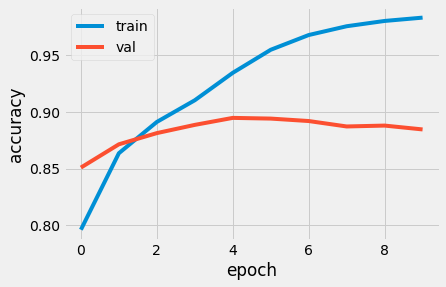

In [19]:
plt.style.use('fivethirtyeight')

# visualize the models accuracy
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc = 'upper left')
plt.show()  

In [20]:
y_predict_test = model.predict(x_test)
y_predict_test = np.argmax(y_predict_test, axis=1)
y_test = np.argmax(y_test.to_numpy(), axis = 1)

In [21]:
print(f1_score(y_test, y_predict_test))
print(accuracy_score(y_test, y_predict_test))

0.8887238151834794
0.8845916795069337


In [22]:
model.save('ModelOne.model', save_format = 'h5')